# Import Packages

In [1]:
import os
import random
import cv2
import random
from PIL import Image
import tifffile as tiff
# import models_pytorch
# import losses_pytorch
import imageio as io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import defaultdict 


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from skimage.morphology import binary_dilation, binary_erosion
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import average_precision_score

import albumentations as A
import albumentations.augmentations.functional as FA
from albumentations.pytorch import ToTensorV2

In [2]:
save_last = r"C:\Saiful_Results\PAN"


In [3]:
import time

today=str(time.ctime().replace(":","-").replace(" ","-"))
print(today)

save_last = save_last+"\\"+today
    
print(save_last)

Thu-Apr-13-16-28-43-2023
C:\Saiful_Results\PAN\Thu-Apr-13-16-28-43-2023


In [4]:
import os



if not os.path.exists(save_last):
    os.makedirs(save_last) 

In [5]:
import segmentation_models_pytorch as smp


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [7]:
def f1_score(y_pred, y_true, threshold=0.5):
    
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    y_pred = ((y_pred>threshold)*1.).type(torch.float32)
    
    tp = torch.sum(y_true*(y_pred))
    tn = torch.sum((1-y_true)*((1-y_pred)))
    fp = torch.sum((1-y_true)*(y_pred))
    fn = torch.sum((y_true)*((1-y_pred)))
    
    pr  = ((tp+1.)/(tp+fp+1.))
    rec = ((tp+1.)/(tp+fn+1.))
    f1  = ((2*pr*rec)/(pr+rec))
    return f1

# Losses

In [8]:
def weighted_bce_loss(output,y,weight):
    epsilon= 1e-7
    output = torch.clamp(output, epsilon, 1.-epsilon)
    logit_output = torch.log(output/(1.-output))
    
    loss = (1.-y)*logit_output + (1.+(weight-1.)*y) * (torch.log(1.+torch.exp(-torch.abs(logit_output))) + torch.maximum(-logit_output,torch.tensor(0.).cuda()))
    return torch.sum(loss)/torch.sum(weight)

def weighted_dice_loss(output,y,weight):
    smooth = 1.
    w,m1,m2 = weight*weight, y, output
    intersection = (m1*m2)
    score = (2.*torch.sum(w*intersection)+smooth)/(torch.sum(w*m1)+torch.sum(w*m2)+smooth)
    loss  = 1.-torch.sum(score)
    return loss

def iou_loss(y_pred, y_true, weight):
    weight = weight*weight
    intersection = y_true * y_pred
    not_true     = 1 - y_true
    union        = y_true + (not_true * y_pred)
    iou          = (torch.sum(intersection * weight)) / (torch.sum(union * weight))

    loss = 1-iou
    return loss
    

def border_loss(output,y,pool_size=(9,9), pad=(4,4)):
    y      = y.type(torch.float32)
    
    output = output.type(torch.float32)
    
    averaged_mask = F.avg_pool2d(y,kernel_size=pool_size,stride=(1,1), padding=pad)
    border = (averaged_mask>0.005).type(torch.float32) * (averaged_mask<0.995).type(torch.float32)
    weight = torch.ones_like(averaged_mask)
    w0     = torch.sum(weight)
    weight+= border*2
    w1     = torch.sum(weight)
    weight*= (w0/w1)
    loss   = weighted_bce_loss(output,y,weight) + weighted_dice_loss(output,y,weight) + iou_loss(output,y,weight)
    return loss

# Functions

In [9]:
################ Metrics #######################
def IoU_pr_rec_f1(y_true, y_pred):
    
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    y_pred = ((y_pred)*1.).type(torch.float32)
    
    tp = torch.sum(y_true*(y_pred))
    tn = torch.sum((1-y_true)*((1-y_pred)))
    fp = torch.sum((1-y_true)*(y_pred))
    fn = torch.sum((y_true)*((1-y_pred)))
    
    pr  = (tp/(tp+fp))
    rec = (tp/(tp+fn))
    f1  = ((2*pr*rec)/(pr+rec))
    tnr = (tn/(tn+fp))
    fpr = (fp/(fp+tn))
    
    intersection = y_true*y_pred
    not_true     = 1 - y_true
    union        = y_true + (not_true * y_pred)
    iou         = (torch.sum(intersection)) / (torch.sum(union))
    
    return iou, pr, rec, f1, tnr, fpr

# Saving Metrics
def metrics():
    x = np.arange(0,1,0.05)
    IoU_      = []
    threshold = []
    precision = []
    recall    = []
    F_score   = []
    mF_score  = []
    TNR       = []
    FPR       = []
    name_list = []

    dict_1 = {'Name':name_list,
              'Precision':precision,
              'Recall':recall,
              'IoU':IoU_,
              'F-Score':F_score,
              'mF-Score':mF_score,
              'Threshold': threshold,
              'True Negative Rate':TNR,
              'False Positive Rate':FPR}
    return dict_1

def best_f_score(name, test_masks, predictions) :
    dict_1 = metrics()
    y = 0
    outer = 0
    check = 0
    x = 0 
    y = 1
    while outer<3:    
        if y>1:
            m = y-1
            y-= m
        z = np.linspace(x, y, 21)
        for i in z:
#             print(i)
            y_true = torch.from_numpy(test_masks)
            y_pred = torch.from_numpy((predictions>i)*1)

            tp = torch.sum(y_true*(y_pred),dim=[1,2,3])
            tn = torch.sum((1-y_true)*((1-y_pred)),dim=[1,2,3])
            fp = torch.sum((1-y_true)*(y_pred),dim=[1,2,3])
            fn = torch.sum((y_true)*((1-y_pred)),dim=[1,2,3])

            pr  = (tp/(tp+fp))
            rec = (tp/(tp+fn))
            score  = ((2*pr*rec)/(pr+rec))
            idx    = torch.isnan(score)
            score[idx] = 0
            score  = torch.sum(score)/len(X_test)
            
            a,b,c,d,e,f = IoU_pr_rec_f1(torch.from_numpy(test_masks), torch.from_numpy(predictions>i))
            dict_1['IoU'].append(a.numpy())
            dict_1['Threshold'].append(i)
            dict_1['Precision'].append(b.numpy())
            dict_1['Recall'].append(c.numpy())
            dict_1['F-Score'].append(d.numpy())
            dict_1['mF-Score'].append(score.cpu().detach().numpy())
            dict_1['True Negative Rate'].append(e.numpy())
            dict_1['False Positive Rate'].append(f.numpy())
            dict_1['Name'].append(name)
            if d>check:
                check = d
                x = i
            else:
                pass
        if outer == 0:
            y = x+0.1
        elif outer==1:
            y = x+0.01
        outer+=1
    
    df = pd.DataFrame(dict_1)
    df = df.sort_values(by=['F-Score'], ascending=False)
    df = df.iloc[0:1]
    
    AP = average_precision_score(test_masks.reshape(-1), predictions.reshape(-1))
    df['AP'] = AP
        
    return df

dict_1 = metrics()

In [10]:
train_dir_LandSAT = r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Pytorch\Year1_Research\New Experimets\Data\Landsat 30m Resolution"
train_dir_Sentinel = r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Pytorch\Year1_Research\New Experimets\Data\Sentinel uint16 Data 0%water and 0%land exclude"


# Load Data

In [11]:
# X_train = np.load(r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_train_4500_30m_res.npy")
# X_val   = np.load(r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_val_500_30m_res.npy")
# X_test  = np.load(r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_test_2000_30m_res.npy")

X_train = np.load(r"{}\X_train_4500_30m_res.npy".format(train_dir_LandSAT))
X_val   = np.load(r"{}\X_val_500_30m_res.npy".format(train_dir_LandSAT))
X_test  = np.load(r"{}\X_test_2000_30m_res.npy".format(train_dir_LandSAT))



Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
Y_val           = (X_val[...,1]-X_val[...,3])/(X_val[...,1]+X_val[...,3])
Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])

Y_train         = ((Y_train<1.)*1).astype('float32')
Y_val           = ((Y_val<1.)*1).astype('float32')
Y_test          = ((Y_test<1.)*1).astype('float32')

X_train         = X_train[...,2::-1].copy()
X_val           = X_val[...,2::-1].copy()
X_test          = X_test[...,2::-1].copy()

X_train         = X_train - X_train.min(axis=(1,2), keepdims=True) 
X_val           = X_val  - X_val.min(axis=(1,2), keepdims=True)
X_test          = X_test - X_test.min(axis=(1,2), keepdims=True) 

X_train         = X_train / X_train.max(axis=(1,2), keepdims=True) 
X_val           = X_val  / X_val.max(axis=(1,2), keepdims=True)
X_test          = X_test / X_test.max(axis=(1,2), keepdims=True) 

C:\Users\HPCL\AppData\Local\Temp\ipykernel_7200\3316677775.py:11: RuntimeWarning: invalid value encountered in true_divide
  Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
C:\Users\HPCL\AppData\Local\Temp\ipykernel_7200\3316677775.py:13: RuntimeWarning: invalid value encountered in true_divide
  Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])


In [12]:
np.random.seed(49)
pop = np.arange(5121)
sample_train = np.random.choice(pop, 4608, replace=False)
sample_val  = np.delete(pop, sample_train)
len(sample_train), len(sample_val)

(4608, 513)

In [13]:
X_sen      = np.load(r"{}\X_train_sentinel_6_channles_5121.npy".format(train_dir_Sentinel))
X_test_sen = np.load(r"{}\X_test_sentinel_6_channles_2053.npy".format(train_dir_Sentinel))
X_train_sen= X_sen[sample_train]
X_val_sen  = X_sen[sample_val]

Y_train_sen         = (X_train_sen[...,1]-X_train_sen[...,3])/(X_train_sen[...,1]+X_train_sen[...,3])
Y_val_sen           = (X_val_sen[...,1]-X_val_sen[...,3])/(X_val_sen[...,1]+X_val_sen[...,3])
Y_test_sen         = (X_test_sen[...,1]-X_test_sen[...,3])/(X_test_sen[...,1]+X_test_sen[...,3])

Y_train_sen         = ((Y_train_sen<1.)*1).astype('float32')
Y_val_sen           = ((Y_val_sen<1.)*1).astype('float32')
Y_test_sen          = ((Y_test_sen<1.)*1).astype('float32')

X_train_sen         = X_train_sen[...,2::-1].copy()
X_val_sen           = X_val_sen[...,2::-1].copy()
X_test_sen          = X_test_sen[...,2::-1].copy()

X_train_sen         = np.clip(X_train_sen, 0, 3558) 
X_val_sen           = np.clip(X_val_sen, 0, 3558)
X_test_sen          = np.clip(X_test_sen, 0, 3558) 

X_train_sen         = (X_train_sen / 3558).astype(np.float32) 
X_val_sen           = (X_val_sen  / 3558).astype(np.float32)
X_test_sen          = (X_test_sen / 3558).astype(np.float32) 

Y_train_sen.shape

(4608, 128, 128)

In [14]:
Y_test= Y_test_sen # np.concatenate((Y_test_LandSAT,Y_test_sen),axis = 0)
Y_test.shape

(2053, 128, 128)

In [15]:
Y_train_sen  = np.array([binary_dilation(binary_dilation(mask))-mask for mask in Y_train_sen], dtype='float64')
Y_val_sen   = np.array([binary_dilation(binary_dilation(mask))-mask for mask in Y_val_sen], dtype='float64')
Y_test_sen  = np.array([binary_dilation(binary_dilation(mask))-mask for mask in Y_test_sen], dtype='float64')

In [16]:
from sklearn.utils import shuffle
X_sen, Y_sen = shuffle(X_train_sen, Y_train_sen, random_state=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


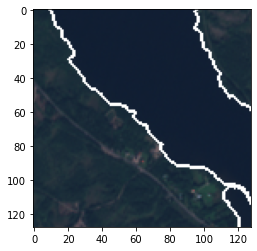

In [17]:
plt.imshow(X_sen[0]+Y_sen[0,...,np.newaxis])

In [18]:
Y_train_LandSAT  = Y_train
Y_val_LandSAT   = Y_val
Y_test_LandSAT = Y_test

In [19]:
Y_train_LandSAT  = np.array([binary_dilation(mask)-mask for mask in Y_train_LandSAT], dtype='float64')
Y_val_LandSAT   = np.array([binary_dilation(mask)-mask for mask in Y_val_LandSAT], dtype='float64')
Y_test_LandSAT  = np.array([binary_dilation(mask)-mask for mask in Y_test_LandSAT], dtype='float64')

In [20]:
X_train_LandSAT        = X_train  
X_val_LandSAT          = X_val  
X_test_LandSAT         = X_test 

In [21]:
X_LS, Y_LS = shuffle(X_train_LandSAT, Y_train_LandSAT, random_state=0)

In [22]:
X_train = np.concatenate((X_LS,X_sen),axis = 0)
print(X_train.shape)

X_val = np.concatenate((X_val_LandSAT,X_val_sen),axis = 0)
print(X_val.shape)

X_test = np.concatenate((X_test_LandSAT,X_test_sen),axis = 0)
print(X_test.shape)

(9108, 128, 128, 3)
(1013, 128, 128, 3)
(4053, 128, 128, 3)


In [23]:
Y_train=  np.concatenate((Y_LS,Y_sen),axis = 0)
print(Y_train.shape)

Y_val=  np.concatenate((Y_val_LandSAT,Y_val_sen),axis = 0)
print(Y_val.shape)

Y_test=  np.concatenate((Y_test_LandSAT,Y_test_sen),axis = 0)
print(Y_test.shape)

(9108, 128, 128)
(1013, 128, 128)
(4106, 128, 128)


In [24]:
X, Y = shuffle(X_train, Y_train, random_state=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


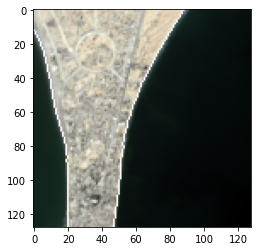

In [25]:
plt.imshow(X[0]+Y[0,...,np.newaxis])

In [26]:
n=8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


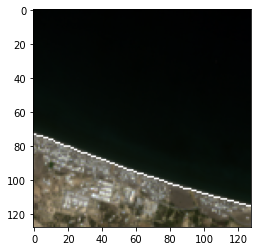

In [27]:
plt.imshow(X[n]+Y[n,...,np.newaxis])

# Pytorch DataLoaders

In [28]:
class NDWIDataset(Dataset):

    def __init__(self, images, masks, transform=None, test_transform=None):
        self.images     = images
        self.masks      = masks
        self.transforms = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transforms:
            augmentations = self.transforms(image=image, mask=mask)
        
        image = augmentations['image']
        mask  = augmentations['mask']
        mask  = mask[np.newaxis,:,:]
        
        return [image.type(torch.float32), 
                mask.type(torch.float32)]
        

In [29]:
def data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, split=0.9, val=True, batch_size=16):
    torch.manual_seed(49)
    random.seed(49)
    trainset= NDWIDataset(X_train, Y_train, transform=trans)

    if val:
        print(f'Training:{len(X_train)}, Validation:{len(X_val)}')
        print(f'Testing: {len(X_test)}')
        
        valset  = NDWIDataset(X_val, Y_val, transform=trans_test)
        testset = NDWIDataset(X_test, Y_test, transform=trans_test)
        image_datasets = {'train': trainset, 'val': valset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True, drop_last=True),#, num_workers=8),
          'val': DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True, drop_last=True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True, drop_last=True)#, num_workers=8)
        }
        
    else:
        print(f'Training:{len(X_train)}')
        print(f'Testing: {len(X_test)}')
        testset = NDWIDataset(X_test, Y_test, transform=trans_test)
        image_datasets = {'train': trainset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    
    return dataloaders

In [30]:
trans = A.Compose([
    ToTensorV2()])
trans_test = A.Compose([
             ToTensorV2()])

In [31]:
def plot_rand(dataloader, set_='train'):
    if set_==None:
        for x,y in dataloader:
            x,y = x.numpy().transpose([0,2,3,1]), y.numpy().squeeze()
            break
    else:
        for x,y in dataloader[set_]:
            x,y = x.numpy().transpose([0,2,3,1]), y.numpy().squeeze()
            break
    rand = np.random.randint(0,x.shape[0])
    plt.subplot(121)
    plt.imshow(x[rand])
    plt.title('Image')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(y[rand])
    plt.title('Contour')
    plt.axis('off')
    plt.show()

In [32]:
dataloaders = data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test)

Training:9108, Validation:1013
Testing: 4053


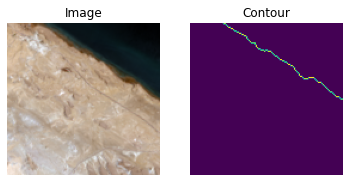

In [33]:
plot_rand(dataloaders)

# Train Function

In [34]:
import time



def train(model, dataloaders, loss_fn, optimizer, acc_fn, random_state=49, epochs=1):
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.backends.cudnn.benchmark = True
    torch.use_deterministic_algorithms(False)
    start = time.time()                                        #Initialize time to calculate time it takes to train model
    model.to(device)                                               #Move model to GPU     

    counter=0
    train_loss, valid_loss = [], []                            #Running training and validation loss
    val_epoch, f1_epoch = [],[]
    AP_epoch=[]
    loss_list = []
    times     = []
#     epoch = 1
    for epoch in range(epochs):
        start_epoch = time.time()
        print(f'Epoch {epoch+1}')
        print(scheduler.get_last_lr())
    

    #########################################Begin Model Training######################################################
    ###################################################################################################################
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()                             # Set training mode all the layers including batchnorm and dropout work in this
                dataloader = dataloaders['train']         #get the training data
            else:
                model.eval()                              # Set model to evaluate mode deactivates the batchnorm and dropout layers
                dataloader = dataloaders['val']           #get the validation data

            running_loss = 0.0                            #running loss to be used for visualization later
            step = 0                                      #Batch number
            
            if phase == 'train':  
                f1 = []
                AP = []
                for inputs, labels in dataloader:
                    x, y = inputs.to(device), labels.to(device)
                    step += 1

                    optimizer.zero_grad()                                   # zero the gradients
                    outputs = model(x)                                      #get model output for a given input

                    #################Metrics###################
                    f1.append(acc_fn(outputs, y).cpu().detach().numpy())
                    AP.append(average_precision_score(y.reshape(-1).cpu().detach().numpy(),  outputs.reshape(-1).cpu().detach().numpy()))

                    ############################################

                    ##################Calculate Loss, backprop, and update###############
                    loss           = loss_fn(outputs, y)
                    train_loss.append(loss.cpu().detach().numpy())
                    loss.backward()
                    optimizer.step()
                    print(f'Current step: {step}, AllocMem (Mb): {torch.cuda.memory_allocated()/1024/1024:.3f}, Loss: {loss:.3f},  F1: {np.mean(f1):.3f},  AP: {np.mean(AP):.3f}', end='\r') 
                    ######################################################################
        
            else:  
                loss_val = []
                f1=[]
                AP =[]
                with torch.no_grad():
                    for inputs, labels in dataloader:
                        x, y = inputs.to(device), labels.to(device)
                        optimizer.zero_grad()                                   # zero the gradients
                        outputs = model(x)                                      #get model output for a given input

                        #################Metrics###################
                        f1.append(acc_fn(outputs, y).cpu().detach().numpy())
                        AP.append(average_precision_score(y.reshape(-1).cpu().detach().numpy(),  outputs.reshape(-1).cpu().detach().numpy()))

                        ############################################

                        ##################Calculate Loss, backprop, and update###############
                        valid_loss.append(loss_fn(outputs, y).cpu().detach().numpy())
                        loss_val.append(valid_loss[-1])
                        
                val_epoch.append(np.mean(loss_val))
                f1_epoch.append(np.mean(f1))
                AP_epoch.append(np.mean(AP))
                print()
                print()
                print(f' Loss val: {val_epoch[-1]:.3f}, F-Score val:{f1_epoch[-1]:.3f}, AP val:{AP_epoch[-1]:.3f} \n') 
                ######################################################################
                
                ##### Check validation #####
#                 if f1_epoch[-1] > f1_epoch[-2]:
#                     counter = 0
#                     print('Counter Reset')
#                 else:
#                     counter+=1
#                     print(f'Counter is {counter}')

            print()
            time_elapsed = time.time() - start_epoch
            times.append(time_elapsed)
            print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
            print('-' * 10)      

        scheduler.step()
        torch.save(model, save_last + '\\' + f'Epcoh_{str(epoch).zfill(3)}'+ '.pth')
        epoch+=1
    #########################################End Model Training######################################################
    ###################################################################################################################
    
    #Total training time including time to test
    time_elapsed = time.time() - start
    print('\n Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return {'Train Loss':train_loss,
            'Valid Loss':valid_loss,
            'Times'     :times,
            'Epochs'    : epoch+1,
            "f1_epoch":f1_epoch
           }

## Prediction Function




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































# Experiments

In [35]:
model_dir = r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Results\Landsat\Final Models\2dil-ndwi"
csv_dir   = r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Results\Landsat\Final Models\2dil-ndwi\F-scores.csv"
dataset = 'Landsat'

### RGB

In [36]:
trans = A.Compose([
    ToTensorV2()])
trans_test = A.Compose([
                ToTensorV2()])

batch_size = 32
dataloaders = data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, batch_size=batch_size)

Training:9108, Validation:1013
Testing: 4053


In [37]:
name = 'PAN'
loss_name = 'BCE+IoU+Dice, 9x9 Border'


model = smp.PAN(encoder_name='resnet34', encoder_weights=None, activation='sigmoid').to(device)
opt = optim.Adam(model.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[100,180], gamma=0.1)
history = train(model, dataloaders, loss_fn = border_loss, optimizer = opt, acc_fn = f1_score, epochs=50)

Epoch 1
[0.003]
Current step: 284, AllocMem (Mb): 343.148, Loss: 1.712,  F1: 0.205,  AP: 0.142
Training complete in 1m 2s
----------


 Loss val: 1.766, F-Score val:0.258, AP val:0.176 


Training complete in 1m 6s
----------
Epoch 2
[0.003]
Current step: 284, AllocMem (Mb): 342.648, Loss: 1.505,  F1: 0.333,  AP: 0.252
Training complete in 0m 49s
----------


 Loss val: 1.636, F-Score val:0.319, AP val:0.266 


Training complete in 0m 54s
----------
Epoch 3
[0.003]
Current step: 284, AllocMem (Mb): 343.148, Loss: 1.473,  F1: 0.381,  AP: 0.310
Training complete in 0m 53s
----------


 Loss val: 1.578, F-Score val:0.355, AP val:0.276 


Training complete in 0m 58s
----------
Epoch 4
[0.003]
Current step: 284, AllocMem (Mb): 342.648, Loss: 1.522,  F1: 0.409,  AP: 0.342
Training complete in 0m 53s
----------


 Loss val: 1.599, F-Score val:0.351, AP val:0.290 


Training complete in 0m 58s
----------
Epoch 5
[0.003]
Current step: 284, AllocMem (Mb): 343.148, Loss: 1.476,  F1: 0.422,  AP: 0

Current step: 284, AllocMem (Mb): 343.148, Loss: 1.107,  F1: 0.561,  AP: 0.517
Training complete in 0m 49s
----------


 Loss val: 1.301, F-Score val:0.509, AP val:0.461 


Training complete in 0m 54s
----------
Epoch 38
[0.003]
Current step: 284, AllocMem (Mb): 342.648, Loss: 1.355,  F1: 0.551,  AP: 0.506
Training complete in 0m 50s
----------


 Loss val: 1.344, F-Score val:0.486, AP val:0.429 


Training complete in 0m 54s
----------
Epoch 39
[0.003]
Current step: 284, AllocMem (Mb): 343.148, Loss: 1.238,  F1: 0.544,  AP: 0.498
Training complete in 0m 48s
----------


 Loss val: 1.317, F-Score val:0.504, AP val:0.455 


Training complete in 0m 52s
----------
Epoch 40
[0.003]
Current step: 284, AllocMem (Mb): 342.648, Loss: 1.153,  F1: 0.554,  AP: 0.510
Training complete in 0m 48s
----------


 Loss val: 1.281, F-Score val:0.516, AP val:0.471 


Training complete in 0m 52s
----------
Epoch 41
[0.003]
Current step: 284, AllocMem (Mb): 343.148, Loss: 1.147,  F1: 0.571,  AP: 0.528
Train

In [38]:
summary(model,(3,128,128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [39]:
df = pd.DataFrame(history['f1_epoch'])
                  
df.to_csv(save_last+ '\\'+ "PAN.csv")

In [52]:
testModel = torch.load(f"{save_last}\\Epcoh_049.pth")

In [53]:
def test(model, dataloaders, loss_fn, acc_fn, random_state=49, epochs=1):
    
    
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.backends.cudnn.benchmark = True
    torch.use_deterministic_algorithms(False)
    start = time.time()                                        #Initialize time to calculate time it takes to train model
    model.to(device)                                               #Move model to GPU     

    model.eval()
    
    counter=0
    #train_loss,
    test_loss = []                         #Running training and validation loss
    loss_epoch, f1_epoch = [0],[0]
    AP_epoch =[0]
    loss_list = []
    times     = []
    
    for epoch in range(epochs):
        start_epoch = time.time()
        print(f'Epoch {epoch}')
        #print(scheduler.get_last_lr())
    

 ################ MODEL TESTING  #############################

        dataloader = dataloaders['test']         #get the training data

        step = 0
        loss_test = []
        f1=[]
        AP = []
        with torch.no_grad():
            for inputs, labels in dataloader:
                x, y = inputs.to(device), labels.to(device)
#                 print(y.shape)
                #optimizer.zero_grad()                                   # zero the gradients
                outputs= model(x)                                      #get model output for a given input
                
#                 print(outputs.shape)
                #################Metrics###################
                f1.append(acc_fn(outputs, y).cpu().detach().numpy())
                AP.append(average_precision_score(y.reshape(-1).cpu().detach().numpy(),  outputs.reshape(-1).cpu().detach().numpy()))
                loss_test.append(loss_fn(outputs, y).cpu().detach().numpy())
            ############################################
                print(f'Current step: {step}, AllocMem (Mb): {torch.cuda.memory_allocated()/1024/1024:.3f},  F1: {np.mean(f1):.3f},  AP: {np.mean(AP):.3f}') 

                step+=1
                ##################Calculate Loss, backprop, and update###############
               
                test_loss.append(loss_test[-1])
        loss_epoch.append(np.mean(loss_test))
        f1_epoch.append(np.mean(f1))
        AP_epoch.append(np.mean(AP))
        print()
        print()
        print(f' Loss test: {loss_epoch[-1]:.3f}, F-Score test:{f1_epoch[-1]:.3f}, AP val:{AP_epoch[-1]:.3f} \n') 
        ######################################################################
                

            

        #scheduler.step()
#         torch.save(model, save_last+ '\\' + f'Epcoh_{str(epoch).zfill(3)}'+ '.pth')
        epoch+=1
    #########################################End Model Training######################################################
    ###################################################################################################################
    
    #Total training time including time to test
    time_elapsed = time.time() - start
    print('\n Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
#     torch.save(model, save_last+ '\\' + f'Feature32_{str(1000)}_images'+ '.pth')
    
    return {
            'f1_epoch':f1_epoch,
            'Epochs': epoch}

In [54]:
test_history = test(testModel, dataloaders, loss_fn = border_loss, acc_fn = f1_score,epochs=1)

Epoch 0
Current step: 0, AllocMem (Mb): 425.327,  F1: 0.003,  AP: 0.005
Current step: 1, AllocMem (Mb): 425.327,  F1: 0.006,  AP: 0.007
Current step: 2, AllocMem (Mb): 425.327,  F1: 0.006,  AP: 0.007
Current step: 3, AllocMem (Mb): 425.327,  F1: 0.006,  AP: 0.007
Current step: 4, AllocMem (Mb): 425.327,  F1: 0.010,  AP: 0.008
Current step: 5, AllocMem (Mb): 425.327,  F1: 0.011,  AP: 0.009
Current step: 6, AllocMem (Mb): 425.327,  F1: 0.011,  AP: 0.010
Current step: 7, AllocMem (Mb): 425.327,  F1: 0.011,  AP: 0.010
Current step: 8, AllocMem (Mb): 425.327,  F1: 0.012,  AP: 0.011
Current step: 9, AllocMem (Mb): 425.327,  F1: 0.012,  AP: 0.012
Current step: 10, AllocMem (Mb): 425.327,  F1: 0.012,  AP: 0.012
Current step: 11, AllocMem (Mb): 425.327,  F1: 0.012,  AP: 0.012
Current step: 12, AllocMem (Mb): 425.327,  F1: 0.012,  AP: 0.013
Current step: 13, AllocMem (Mb): 425.327,  F1: 0.012,  AP: 0.013
Current step: 14, AllocMem (Mb): 425.327,  F1: 0.012,  AP: 0.013
Current step: 15, AllocMem 

In [55]:
dataloaderSentinel = data(trans, trans_test, X_sen, Y_sen, X_val_sen, Y_val_sen, X_test_sen, Y_test_sen, batch_size=batch_size)


dataloaderLandSAT = data(trans, trans_test, X_LS, Y_LS, X_val_LandSAT, Y_val_LandSAT, X_test_LandSAT, Y_test_LandSAT, batch_size=batch_size)




Training:4608, Validation:513
Testing: 2053
Training:4500, Validation:500
Testing: 2000


In [56]:
test_Sen = test(testModel, dataloaderSentinel, loss_fn = border_loss, acc_fn = f1_score, epochs=1)

Epoch 0
Current step: 0, AllocMem (Mb): 425.327,  F1: 0.388,  AP: 0.320
Current step: 1, AllocMem (Mb): 425.327,  F1: 0.401,  AP: 0.331
Current step: 2, AllocMem (Mb): 425.327,  F1: 0.396,  AP: 0.318
Current step: 3, AllocMem (Mb): 425.327,  F1: 0.408,  AP: 0.333
Current step: 4, AllocMem (Mb): 425.327,  F1: 0.404,  AP: 0.327
Current step: 5, AllocMem (Mb): 425.327,  F1: 0.436,  AP: 0.365
Current step: 6, AllocMem (Mb): 425.327,  F1: 0.447,  AP: 0.377
Current step: 7, AllocMem (Mb): 425.327,  F1: 0.462,  AP: 0.397
Current step: 8, AllocMem (Mb): 425.327,  F1: 0.465,  AP: 0.401
Current step: 9, AllocMem (Mb): 425.327,  F1: 0.475,  AP: 0.413
Current step: 10, AllocMem (Mb): 425.327,  F1: 0.482,  AP: 0.421
Current step: 11, AllocMem (Mb): 425.327,  F1: 0.491,  AP: 0.431
Current step: 12, AllocMem (Mb): 425.327,  F1: 0.489,  AP: 0.431
Current step: 13, AllocMem (Mb): 425.327,  F1: 0.494,  AP: 0.437
Current step: 14, AllocMem (Mb): 425.327,  F1: 0.500,  AP: 0.443
Current step: 15, AllocMem 

In [57]:
test_LS = test(testModel, dataloaderLandSAT, loss_fn = border_loss, acc_fn = f1_score, epochs=1)

Epoch 0
Current step: 0, AllocMem (Mb): 425.327,  F1: 0.003,  AP: 0.005
Current step: 1, AllocMem (Mb): 425.327,  F1: 0.006,  AP: 0.007
Current step: 2, AllocMem (Mb): 425.327,  F1: 0.006,  AP: 0.007
Current step: 3, AllocMem (Mb): 425.327,  F1: 0.006,  AP: 0.007
Current step: 4, AllocMem (Mb): 425.327,  F1: 0.010,  AP: 0.008
Current step: 5, AllocMem (Mb): 425.327,  F1: 0.011,  AP: 0.009
Current step: 6, AllocMem (Mb): 425.327,  F1: 0.011,  AP: 0.010
Current step: 7, AllocMem (Mb): 425.327,  F1: 0.011,  AP: 0.010
Current step: 8, AllocMem (Mb): 425.327,  F1: 0.012,  AP: 0.011
Current step: 9, AllocMem (Mb): 425.327,  F1: 0.012,  AP: 0.012
Current step: 10, AllocMem (Mb): 425.327,  F1: 0.012,  AP: 0.012
Current step: 11, AllocMem (Mb): 425.327,  F1: 0.012,  AP: 0.012
Current step: 12, AllocMem (Mb): 425.327,  F1: 0.012,  AP: 0.013
Current step: 13, AllocMem (Mb): 425.327,  F1: 0.012,  AP: 0.013
Current step: 14, AllocMem (Mb): 425.327,  F1: 0.012,  AP: 0.013
Current step: 15, AllocMem 